### This notebook fits polynomials to the parsec isochrone data, picks the polynomial function that minimizes the frobenius norm of the residuals, calculates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr
import statsmodels.api as sm
import itertools as it

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

In [2]:

data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [3]:
u_des = objs['DECAM_U']
g_des = objs['DES_G']
r_des = objs['DES_R']
i_des = objs['DES_I']
z_des = objs['DES_Z']
feh_des = objs['FEH']
u_g_des = u_des - g_des
g_r_des = g_des - r_des


In [4]:
u_g_des = u_g_des + .3

In [5]:
#apply shift found in isochrone_minimize_residuals_01OCT2019
u_g_dex = u_g_des - .005
g_r_dex = g_r_des - .005

In [6]:
#cuts and shifts from isochrone_minimize_residuals_01OCT2019
#reduce area to around selection box
selected = np.where((u_g_des>=0.4)&(u_g_des<=1.3)&(g_r_des>=0)&(g_r_des<=0.4))
u_g_des = u_g_des[selected]
g_r_des = g_r_des[selected]
feh_des = feh_des[selected]






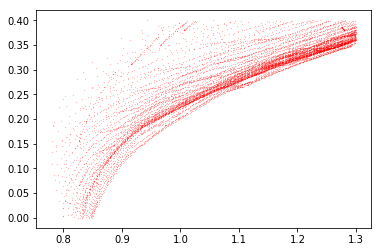

In [7]:
plt.scatter(u_g_des,g_r_des,c='r',s=.01)

### fit polynomials to above parsec isochrone data

In [8]:
#following: https://github.com/JoshuaPovick/Magellanic_Ages/blob/master/NEW_PARSEC.ipynb
#Create a list of all possible models
y1 = u_g_des
y2 = g_r_des
y12 = np.multiply(y1,y2)
y1sq = y1**2
y2sq = y2**2
y1sq2 = np.multiply(y1sq,y2)
y2sq1 = np.multiply(y2sq,y1)
y1th = y1**3
y2th = y2**3

models = []
models_str = []
all_var_str = ['y1','y2','y12','y1sq','y2sq','y1sq2','y2sq1','y1th','y2th']
all_var = [y1,y2,y12,y1sq,y2sq,y1sq2,y2sq1,y1th,y2th]

In [9]:
for i in range(2, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))

In [10]:
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2':
        idx.append(j)
models = np.array(models)[idx]
models_str = np.array(models_str)[idx]

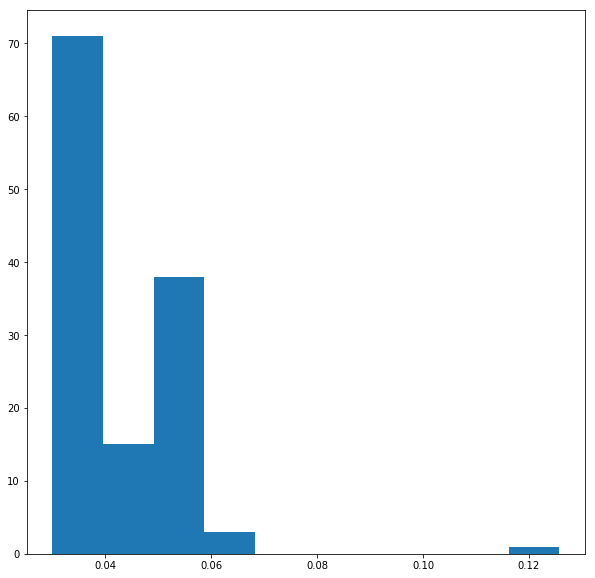

0.030007038910651058
[array(['y1', 'y2', 'y1sq', 'y1sq2', 'y2sq1', 'y1th', 'y2th'], dtype='<U5')]
[array([ -49.27522572,  125.01890136,  -10.81052376, -102.59014183,
         17.52793863,  -23.75625663,   26.27050131,   -3.16243291])]


In [11]:
#fit all models
model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(feh_des,pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - feh_des
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(np.array(models_str)[best])
print(np.asarray(model_params)[best])


In [12]:

#evaluate each polynomial for:
#x= u_g_des
#y= g_r_des
fitted = []

for i in np.arange(0,len(model_params)):
    temp = []
    temp.append(model_params[i][0]*(np.ones(len(u_g_des))))
    for j in np.arange(1,len(model_params[i])):
        if models_str[i][(j-1)] == 'y1':
            temp.append((u_g_des*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y2':
            temp.append((g_r_des*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y12':
            temp.append((u_g_des*g_r_des*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y1sq':
            temp.append((u_g_des**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2sq':
            temp.append((g_r_des**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y1sq2':
            temp.append(g_r_des*(u_g_des**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2sq1':
            temp.append((u_g_des*model_params[i][j])*(g_r_des**2))
        elif models_str[i][(j-1)] == 'y1th':
            temp.append((u_g_des**3)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2th':
            temp.append((g_r_des**3)*model_params[i][j])
    print(temp)
    print(len(temp))
    sums = temp[0]
    for k in np.arange(1,len(temp)):
        sums += temp[k]
    fitted.append((sums))
        
        
        

[array([-4.45129573, -4.45129573, -4.45129573, ..., -4.45129573,
       -4.45129573, -4.45129573]), array([4.477211 , 4.272836 , 4.030439 , ..., 6.1692333, 6.1454697,
       6.1359644], dtype=float32), array([-1.5395226, -1.4048148, -1.2123754, ..., -1.3894207, -1.3470832,
       -1.3432347], dtype=float32)]
3
[array([-10.63874839, -10.63874839, -10.63874839, ..., -10.63874839,
       -10.63874839, -10.63874839]), array([11.023344, 10.520152,  9.923346, ..., 15.189273, 15.130764,
       15.107362], dtype=float32), array([5.2156067, 4.7592425, 4.107295 , ..., 4.7070904, 4.5636587,
       4.550621 ], dtype=float32), array([-7.3185663, -6.373349 , -5.188261 , ..., -9.101172 , -8.789858 ,
       -8.75119  ], dtype=float32)]
4
[array([-16.41793739, -16.41793739, -16.41793739, ..., -16.41793739,
       -16.41793739, -16.41793739]), array([25.868399, 24.687565, 23.287043, ..., 35.644554, 35.50725 ,
       35.452335], dtype=float32), array([-2.2404876, -2.0444455, -1.764386 , ..., -2.0220423, 

[array([-13.38979996, -13.38979996, -13.38979996, ..., -13.38979996,
       -13.38979996, -13.38979996]), array([12.595689, 12.020723, 11.33879 , ..., 17.355837, 17.288982,
       17.262243], dtype=float32), array([12.751203, 11.635476, 10.041583, ..., 11.507973, 11.15731 ,
       11.125434], dtype=float32), array([-22.613955, -18.829662, -14.024217, ..., -18.419247, -17.313831,
       -17.215044], dtype=float32), array([-17.422285, -14.479565, -11.118488, ..., -29.853834, -28.721596,
       -28.551012], dtype=float32), array([28.647655, 22.764797, 15.993222, ..., 32.152008, 30.106016,
       29.887941], dtype=float32), array([1.6403949, 1.4258521, 1.1966931, ..., 4.291601 , 4.2421985,
       4.2225447], dtype=float32), array([-4.8206544, -3.662731 , -2.3542857, ..., -3.5436358, -3.2294683,
       -3.201868 ], dtype=float32)]
8
[array([-43.88281041, -43.88281041, -43.88281041, ..., -43.88281041,
       -43.88281041, -43.88281041]), array([100.4963 ,  95.90887,  90.46797, ..., 138.47574

### Calculate frobenius norm ( square root of sum of squares ) the residuals

In [13]:
norm = []
for model in fitted:
    residuals = feh_des - model
    temp = 0
    for element in residuals:
        temp += (element**2)
    norm.append(np.sqrt(np.sum(temp)))
        
        
        

### Plot histogram of norm of the residuals

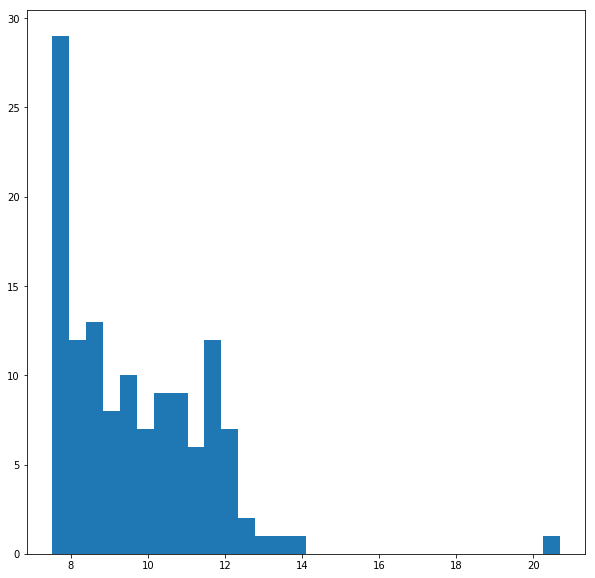

In [16]:
plt.figure(figsize=[10,10])
plt.hist(norm,bins=30)
plt.show()

In [15]:
small, = np.where(np.asarray(norm)<=8)

### Plot residuals with norm < 8

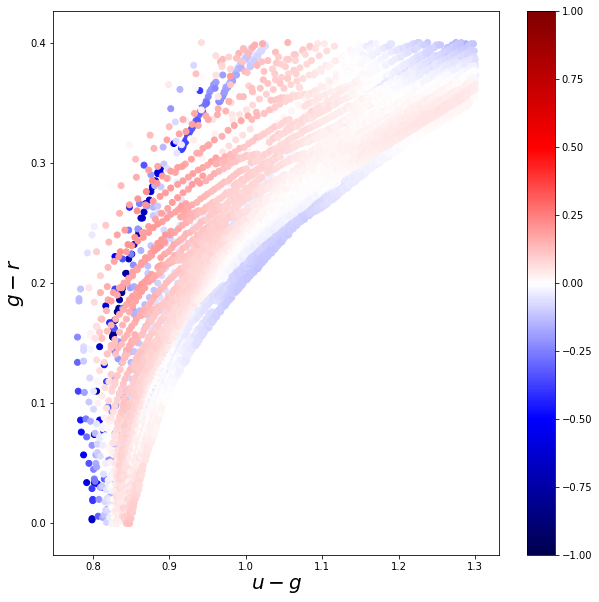

[-2.36907671 -2.34345911 -2.3215327  ...  0.14277246  0.15897038
  0.1566694 ]
64
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2']
[-30.27107403  57.21451375  41.81240602 -91.44107558 -26.75812214
 -17.09270894  51.31767896]


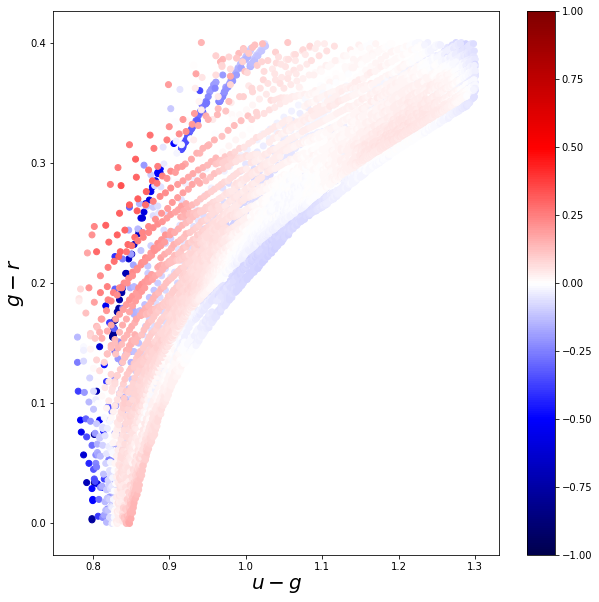

[-2.448536   -2.49182185 -2.56307491 ...  0.19382922  0.2247254
  0.22041742]
66
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1th']
[ -47.59799727  121.37195277  -14.58771245   19.99343763 -102.08027885
  -22.86789273   27.94586264]


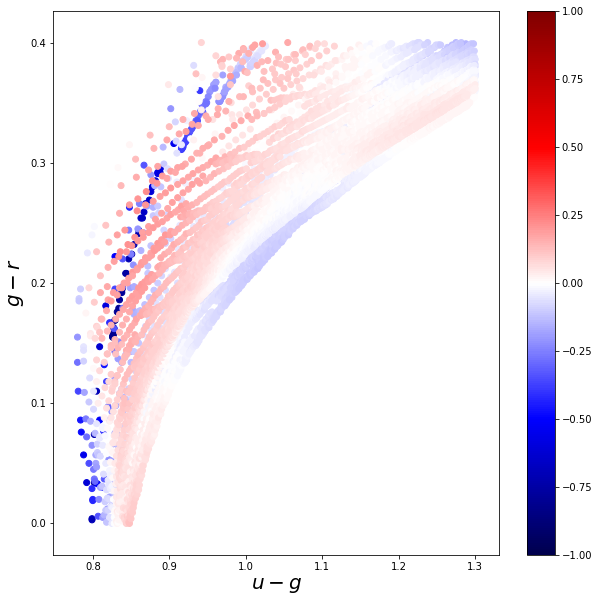

[-2.38519435 -2.34496837 -2.32300501 ...  0.14764757  0.16043873
  0.15774269]
68
['y1' 'y2' 'y12' 'y1sq' 'y1sq2' 'y2sq1']
[ -32.48897843   63.29882606   42.25653474 -102.05389893  -30.84015792
   63.06208223  -19.83531053]


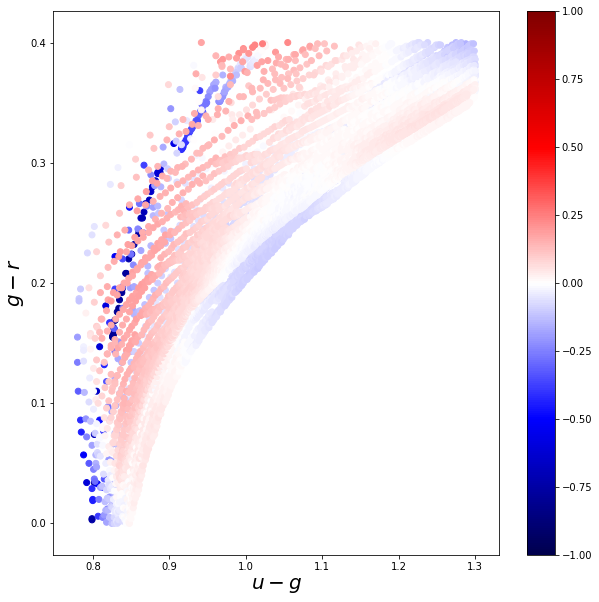

[-2.47471716 -2.37138225 -2.29371299 ...  0.15095864  0.16018222
  0.15716491]
70
['y1' 'y2' 'y12' 'y1sq' 'y1sq2' 'y2th']
[ -33.35587062   64.53404579   47.95211555 -112.00101853  -30.94888736
   63.14795591  -28.74912474]


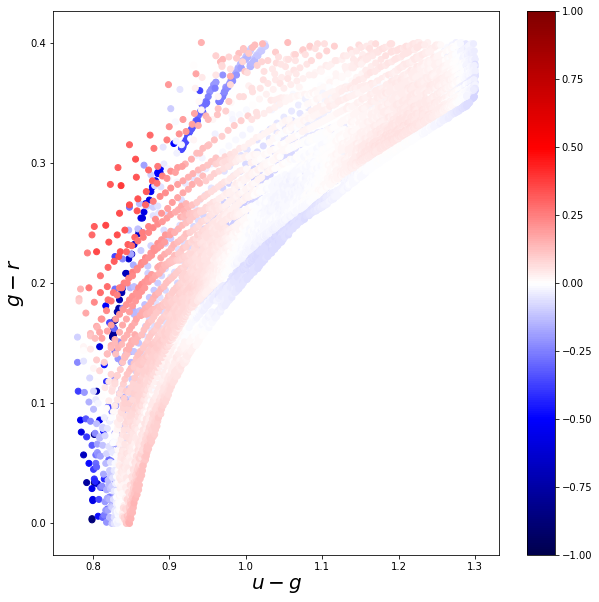

[-2.45680185 -2.50197407 -2.60304137 ...  0.21045403  0.24544672
  0.24045519]
71
['y1' 'y2' 'y12' 'y1sq' 'y2sq1' 'y1th']
[ -53.70837446  142.7870051   -30.29159327   38.35534127 -124.62936621
  -27.13398331   34.8030925 ]


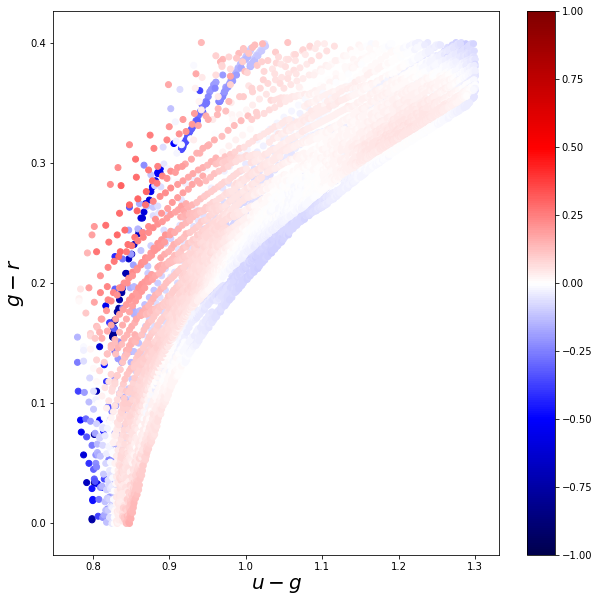

[-2.43641822 -2.46876816 -2.52600543 ...  0.18717702  0.21452875
  0.21041484]
85
['y1' 'y2' 'y1sq' 'y2sq' 'y1sq2' 'y1th']
[-45.30553679 112.19135806  -4.54484024 -90.71913616 -21.89478056
   9.31421727  23.5684591 ]


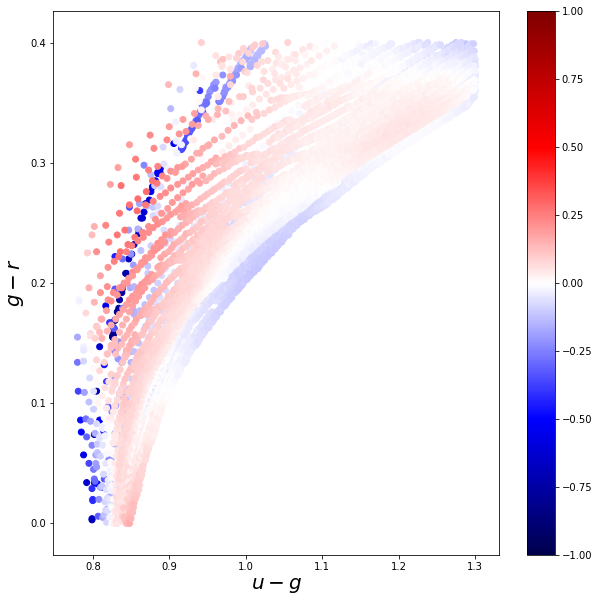

[-2.39273403 -2.43802074 -2.4901645  ...  0.18024268  0.21067699
  0.2070935 ]
87
['y1' 'y2' 'y1sq' 'y2sq' 'y2sq1' 'y1th']
[-41.41470508  99.58826112   2.02915698 -79.24389934 -43.35124212
  26.16194482  21.18611924]


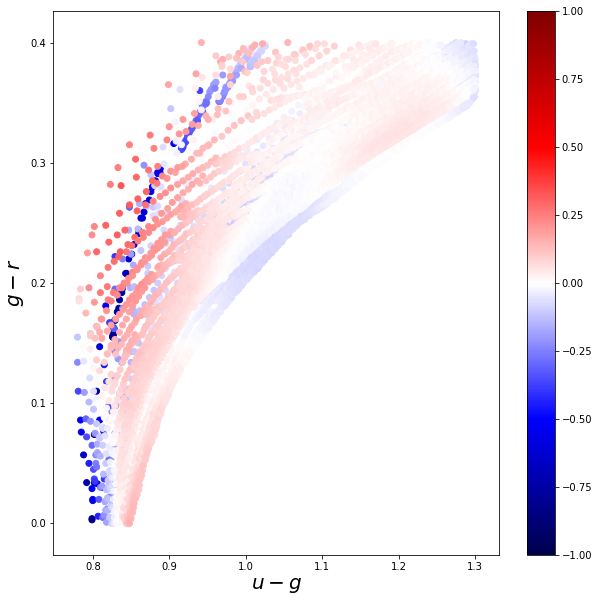

[-2.45586428 -2.47766813 -2.54530701 ...  0.19572464  0.22212473
  0.21751085]
90
['y1' 'y2' 'y1sq' 'y1sq2' 'y2sq1' 'y1th']
[ -49.09323725  124.48326429  -10.84555537 -102.0637285    17.94191702
  -25.80121918   26.08023522]


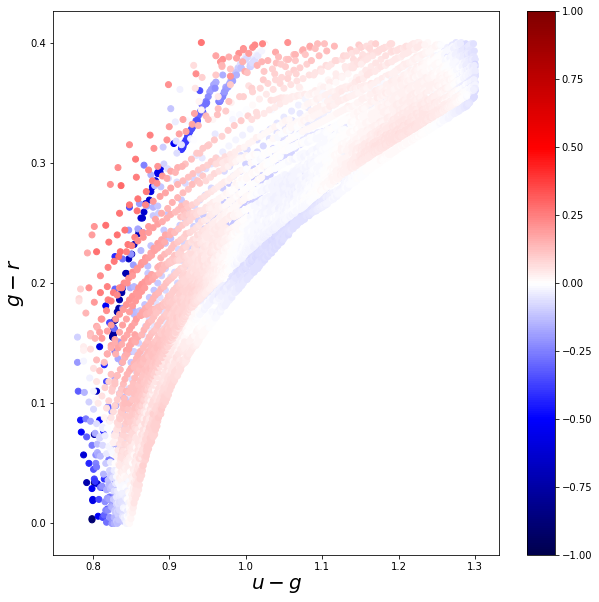

[-2.57261272 -2.51920684 -2.52379997 ...  0.20266204  0.22760503
  0.22255234]
92
['y1' 'y2' 'y1sq' 'y1sq2' 'y1th' 'y2th']
[ -51.24039598  130.711158     -9.96406528 -108.35179037   11.85721528
   28.58027356  -37.93513605]


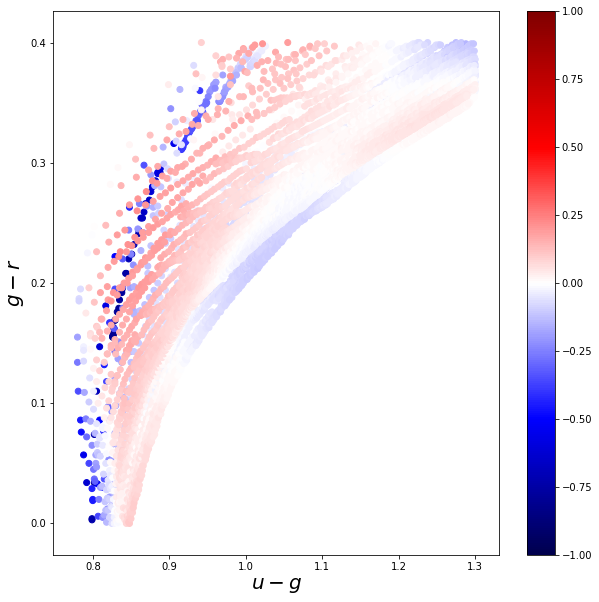

[-2.39086319 -2.33888889 -2.31904996 ...  0.15255164  0.16264712
  0.1595956 ]
99
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1']
[ -34.48277164   68.65875757   43.10516767 -112.1306985   -34.37358713
   15.13386282   73.50461767  -37.05907095]


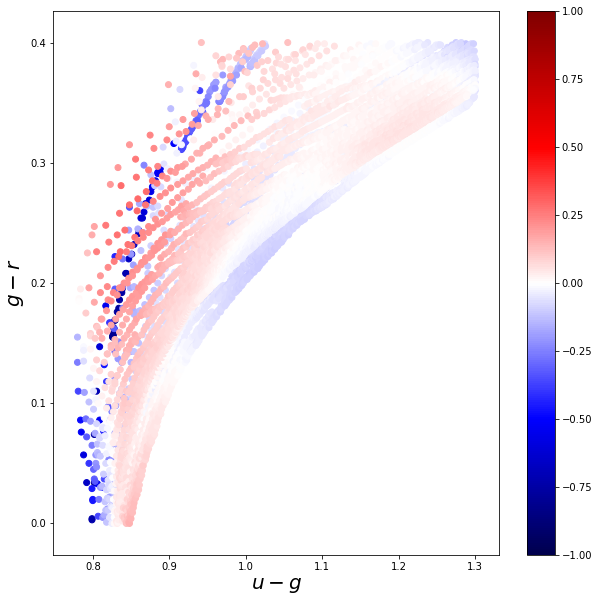

[-2.4255802  -2.45141786 -2.50076595 ...  0.18348199  0.20906764
  0.20508295]
100
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y1th']
[-43.89090908 106.56421626   1.55888929 -12.07509994 -83.81090629
 -21.20161592  14.84645607  20.93741982]


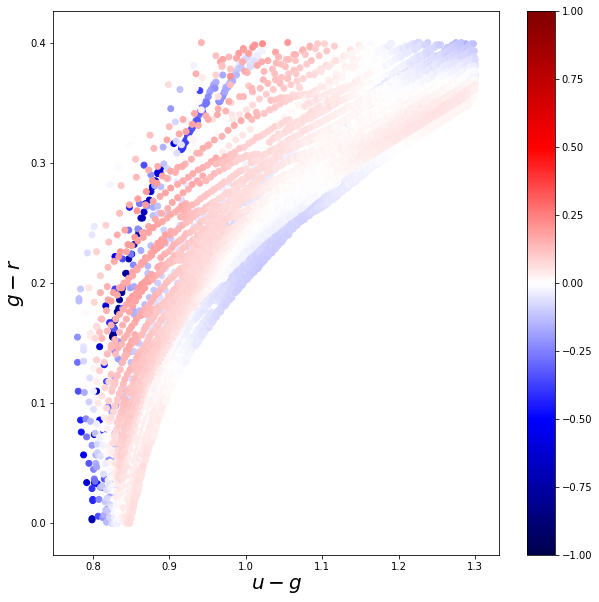

[-2.44328844 -2.37090963 -2.31320333 ...  0.1465528   0.15827561
  0.15557778]
101
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y2th']
[ -31.96851647   61.36978524   44.69528573 -102.1365762   -29.22044553
   -7.55933016   57.85157964  -16.7761005 ]


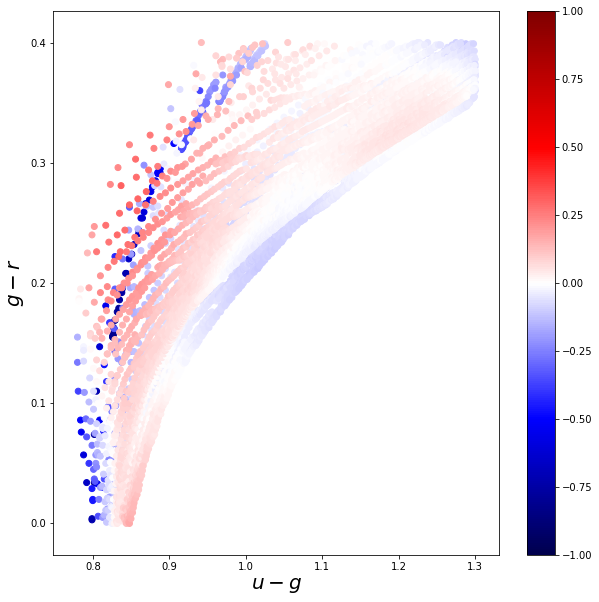

[-2.42855628 -2.47284969 -2.5335085  ...  0.18643169  0.21629171
  0.21231846]
102
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y2sq1' 'y1th']
[-44.59512969 110.76485991  -6.50944447  10.34774445 -90.91009986
 -33.46859843  13.20910267  24.60263421]


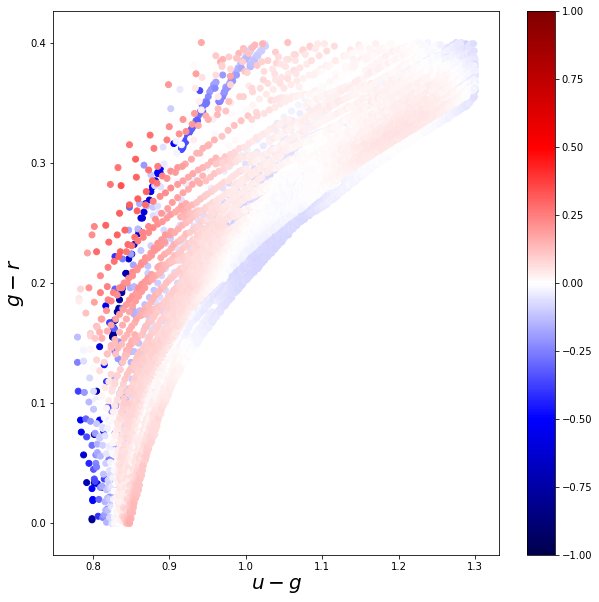

[-2.46726105 -2.50168447 -2.56672993 ...  0.19532585  0.22583969
  0.22141986]
104
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1th' 'y2th']
[ -48.23551194  123.4494579   -15.51232651   20.73920628 -104.1381979
  -20.91324445   28.54694197   -3.7255998 ]


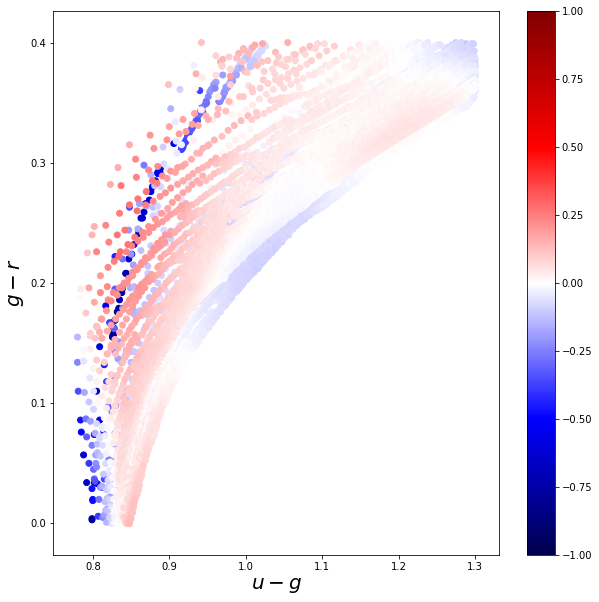

[-2.42361547 -2.42305137 -2.46049918 ...  0.18175863  0.20177673
  0.19765972]
105
['y1' 'y2' 'y12' 'y1sq' 'y1sq2' 'y2sq1' 'y1th']
[-43.83318974 103.87248382  10.69585248 -41.4486198  -77.12337371
  36.22400476 -23.25846538  16.7313234 ]


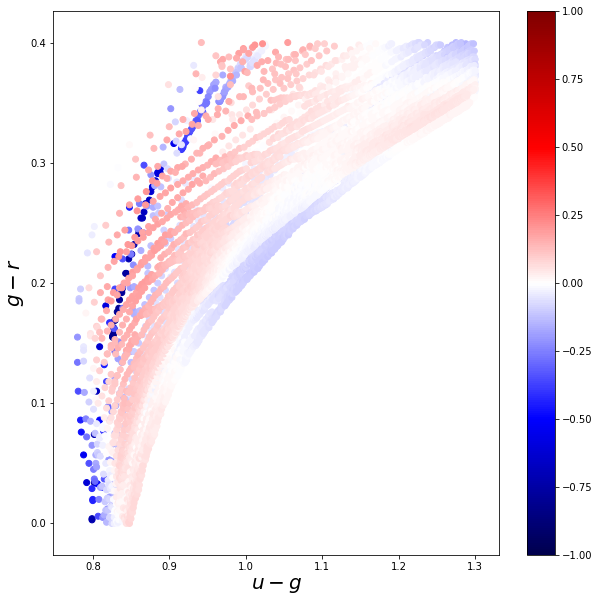

[-2.427059   -2.36126346 -2.3158306  ...  0.148476    0.1596209
  0.15679976]
106
['y1' 'y2' 'y12' 'y1sq' 'y1sq2' 'y2sq1' 'y2th']
[ -32.80274821   63.80254608   44.10923826 -105.38278881  -30.94798702
   63.05990457  -12.37299595  -11.21293498]


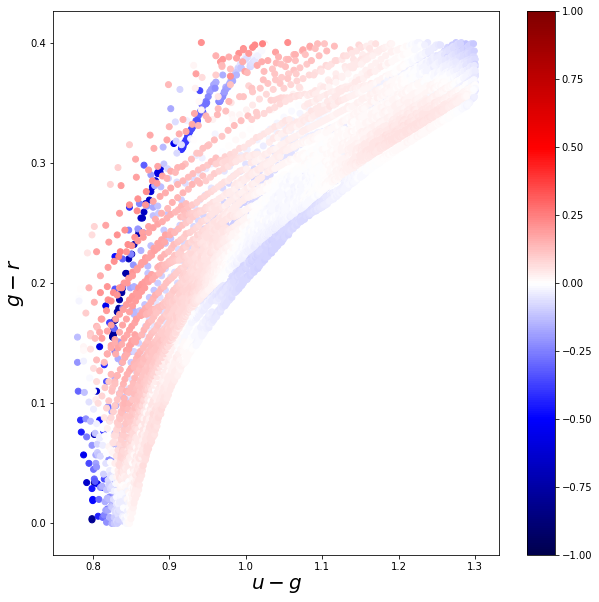

[-2.51486261 -2.43649121 -2.40165766 ...  0.1800565   0.19494919
  0.1907057 ]
107
['y1' 'y2' 'y12' 'y1sq' 'y1sq2' 'y1th' 'y2th']
[-42.9203523   98.42747988  22.69010868 -63.26749365 -69.41252785
  40.86310859  13.91262513 -32.64973372]


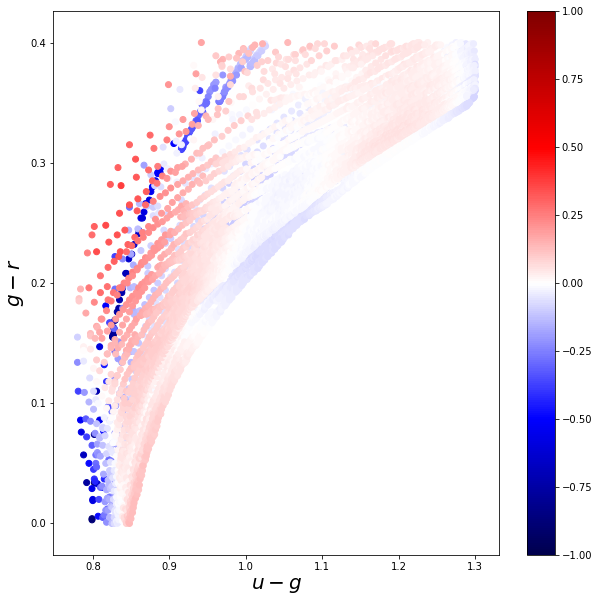

[-2.47656879 -2.50949746 -2.59923077 ...  0.2106922   0.24494879
  0.23989235]
108
['y1' 'y2' 'y12' 'y1sq' 'y2sq1' 'y1th' 'y2th']
[ -53.80977073  142.88656014  -29.39387293   36.75005131 -124.547899
  -23.57321943   34.76294432   -5.34043397]


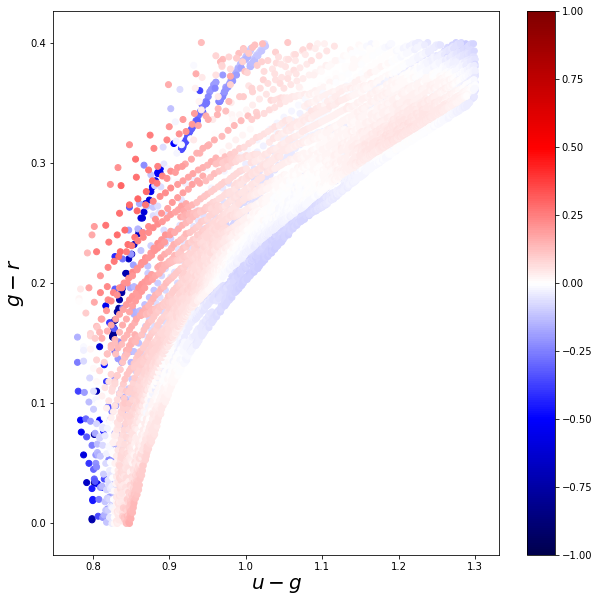

[-2.4287872  -2.46416172 -2.51971057 ...  0.18525431  0.21301231
  0.20902839]
114
['y1' 'y2' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y1th']
[-44.38943222 109.21147552  -2.98655    -87.98222971 -27.1725534
   7.13870703   6.32822563  22.98162951]


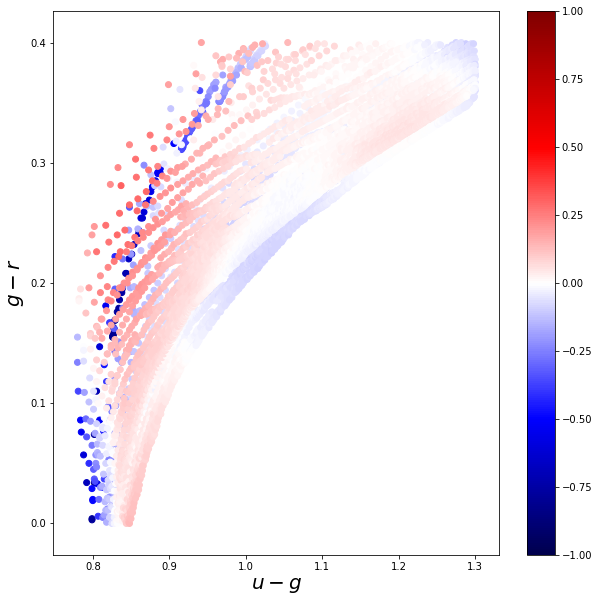

[-2.47465752 -2.48822765 -2.53168664 ...  0.18959404  0.21573968
  0.21143789]
116
['y1' 'y2' 'y1sq' 'y2sq' 'y1sq2' 'y1th' 'y2th']
[-46.43099298 115.72422158  -5.66944804 -94.03448616 -17.91833459
  10.05127267  24.44691568  -7.51736829]


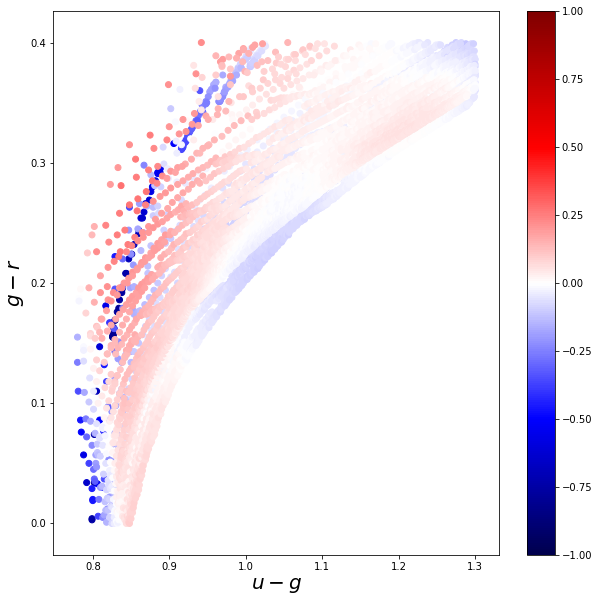

[-2.52539456 -2.51278098 -2.51485104 ...  0.18403632  0.20909506
  0.20501737]
117
['y1' 'y2' 'y1sq' 'y2sq' 'y2sq1' 'y1th' 'y2th']
[-44.03185347 107.60521475   0.2232003  -86.69026822 -37.87735182
  34.53795127  23.21546675 -24.56313394]


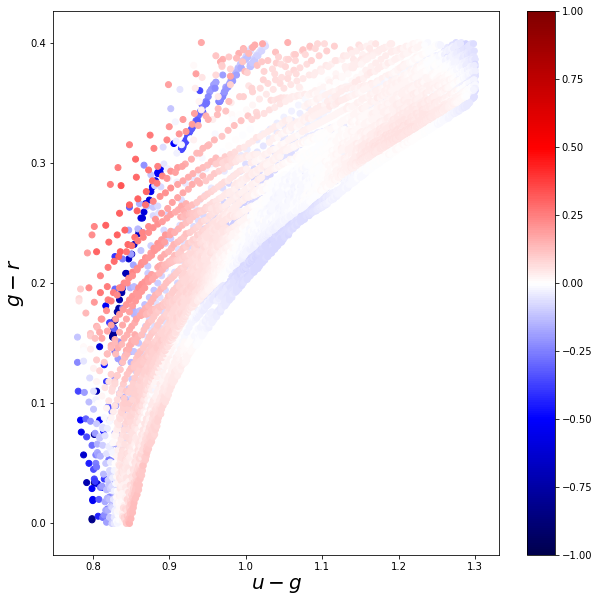

[-2.46846152 -2.48352057 -2.54511521 ...  0.19617537  0.22227749
  0.21763889]
118
['y1' 'y2' 'y1sq' 'y1sq2' 'y2sq1' 'y1th' 'y2th']
[ -49.27522572  125.01890136  -10.81052376 -102.59014183   17.52793863
  -23.75625663   26.27050131   -3.16243291]


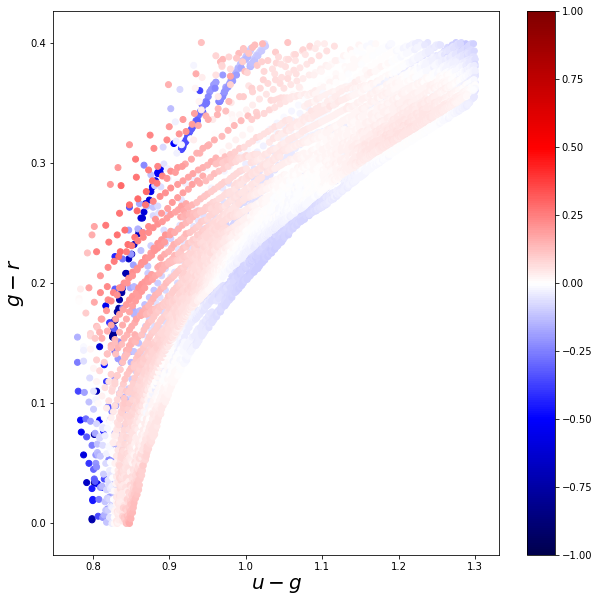

[-2.42537365 -2.45283617 -2.50291728 ...  0.1835565   0.20949467
  0.20552893]
120
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y1th']
[-43.88281041 106.6839454    1.04608965 -10.35541604 -84.16866458
 -22.50765253  13.56091864   1.44761583  21.1778807 ]


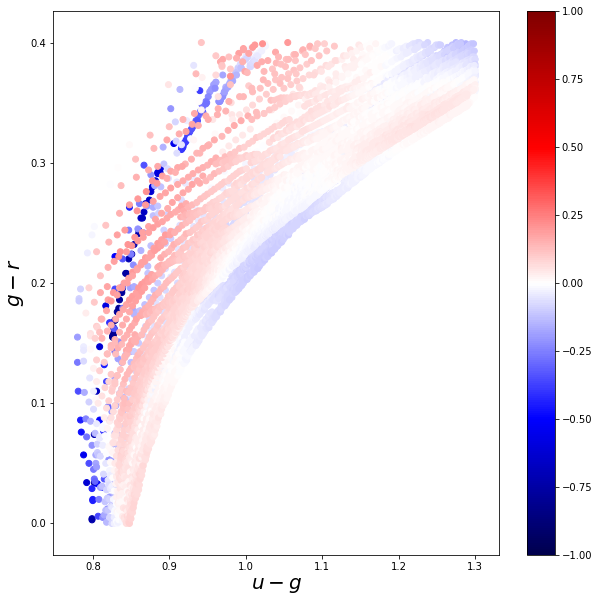

[-2.41496232 -2.3522594  -2.31636274 ...  0.15071854  0.16105473
  0.1580987 ]
121
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y2th']
[ -33.72440955   66.40238361   43.88363409 -109.41444837  -32.74247447
    7.85187777   68.47857117  -23.99127838   -7.18277988]


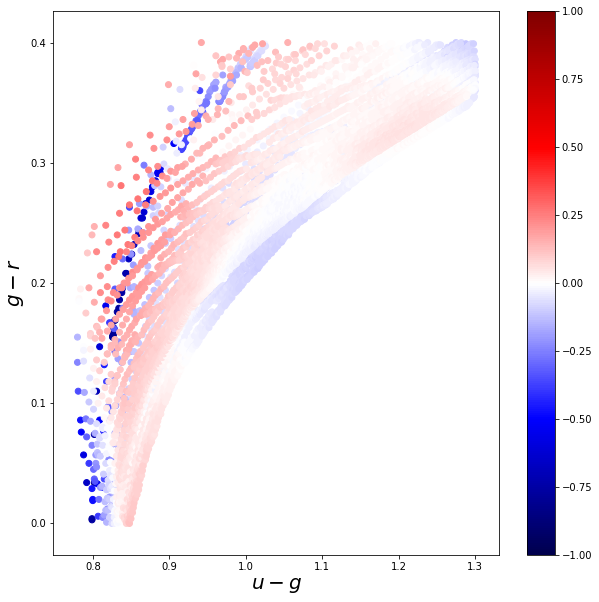

[-2.4697075  -2.46205063 -2.48367111 ...  0.18324595  0.20534178
  0.20120587]
122
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y1th' 'y2th']
[-44.09360273 106.0129507    6.05037761 -24.16014022 -81.66469818
 -14.78946904  21.44318705  19.56749758 -10.8105093 ]


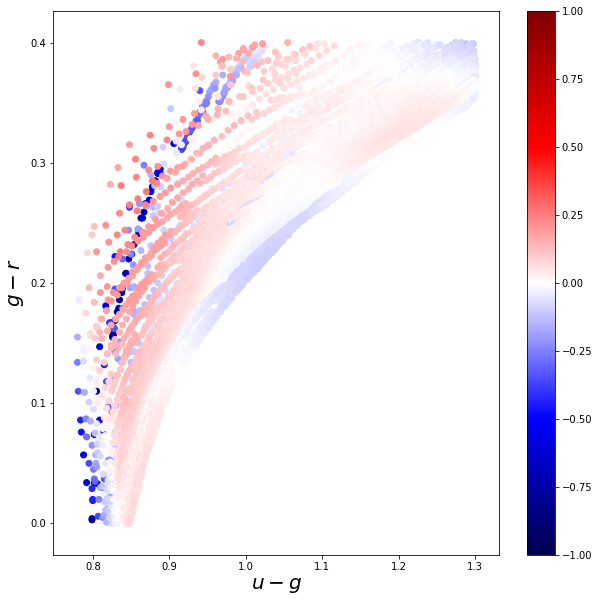

[-2.53023939 -2.50635378 -2.49276792 ...  0.18094797  0.20524294
  0.20130713]
123
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y2sq1' 'y1th' 'y2th']
[-42.57764261 102.25207356   5.20125804  -6.48301499 -80.91300961
 -42.94294321  44.37612238  21.49242558 -29.61600327]


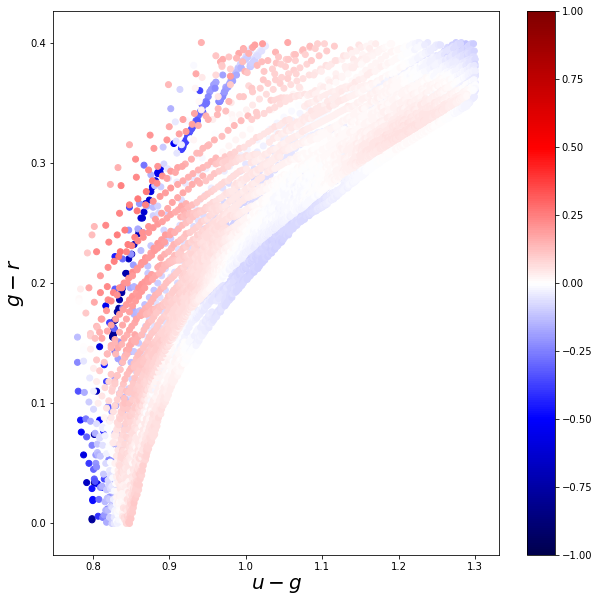

[-2.45438356 -2.43384889 -2.45252601 ...  0.18176689  0.20039341
  0.19620636]
124
['y1' 'y2' 'y12' 'y1sq' 'y1sq2' 'y2sq1' 'y1th' 'y2th']
[-43.85675466 103.49150633  12.68060036 -45.0877653  -76.33766296
  36.72500811 -17.58098071  16.41796799  -8.43470103]


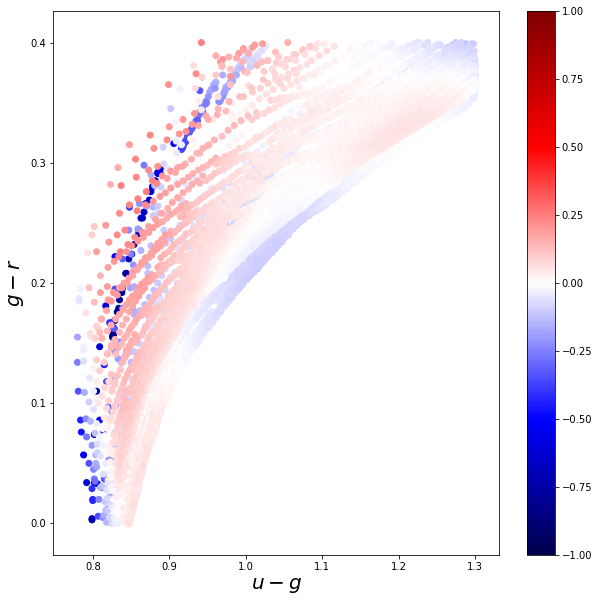

[-2.54948701 -2.51920595 -2.49124565 ...  0.179826    0.20538638
  0.20155857]
126
['y1' 'y2' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y1th' 'y2th']
[-41.72344293  99.90563197   5.46029773 -79.78463426 -54.95145296
  -8.7798619   63.2525474   22.05412176 -37.23530549]


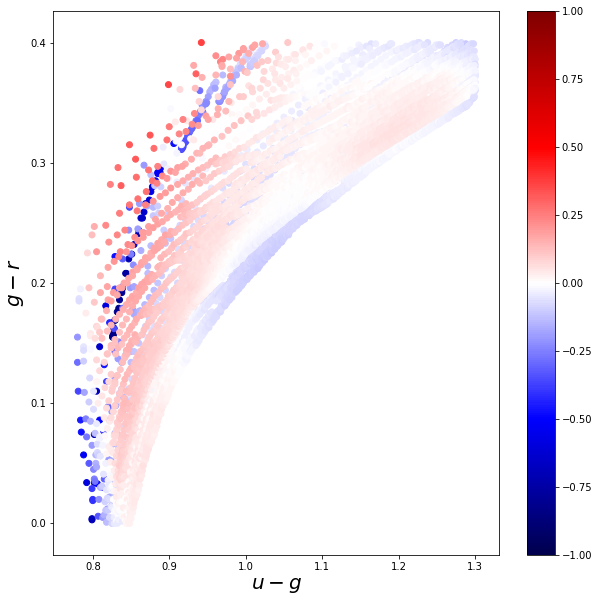

[-2.67195475 -2.66335094 -2.62137306 ...  0.19096815  0.23137867
  0.22752487]
127
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y1th' 'y2th']
[ -44.27677739  115.67737032  -24.5631504    93.56679366 -108.01788098
 -118.19369438  -78.89488701  150.57376231   37.64771891  -65.50782695]


In [17]:
#plot residuals 

for index in small:
    plt.figure(figsize=(10,10))
    plt.scatter(u_g_des,g_r_des,c=(feh_des-fitted[index]),cmap='seismic',vmin=-1,vmax=1)
    plt.colorbar()
    plt.xlabel('$u-g$',fontsize=20)
    plt.ylabel('$g-r$',fontsize=20)
    plt.show()
    print(fitted[index])
    print(index)
    print(models_str[index])
    print(model_params[index])
    

### Look at the residuals with the minimum norm

In [19]:
minimum = np.where(norm==np.array(norm).min())

In [20]:
minimum

(array([127]),)

### The minimum norm of residuals is the last plot above. Investigating the residuals of this polynomial(u_g_des,g_r_des) more

In [27]:
x = np.arange(-4,1,.001)

In [28]:
len(x)

5000

In [29]:
y = (np.nanmedian(delta))*np.ones(5000)

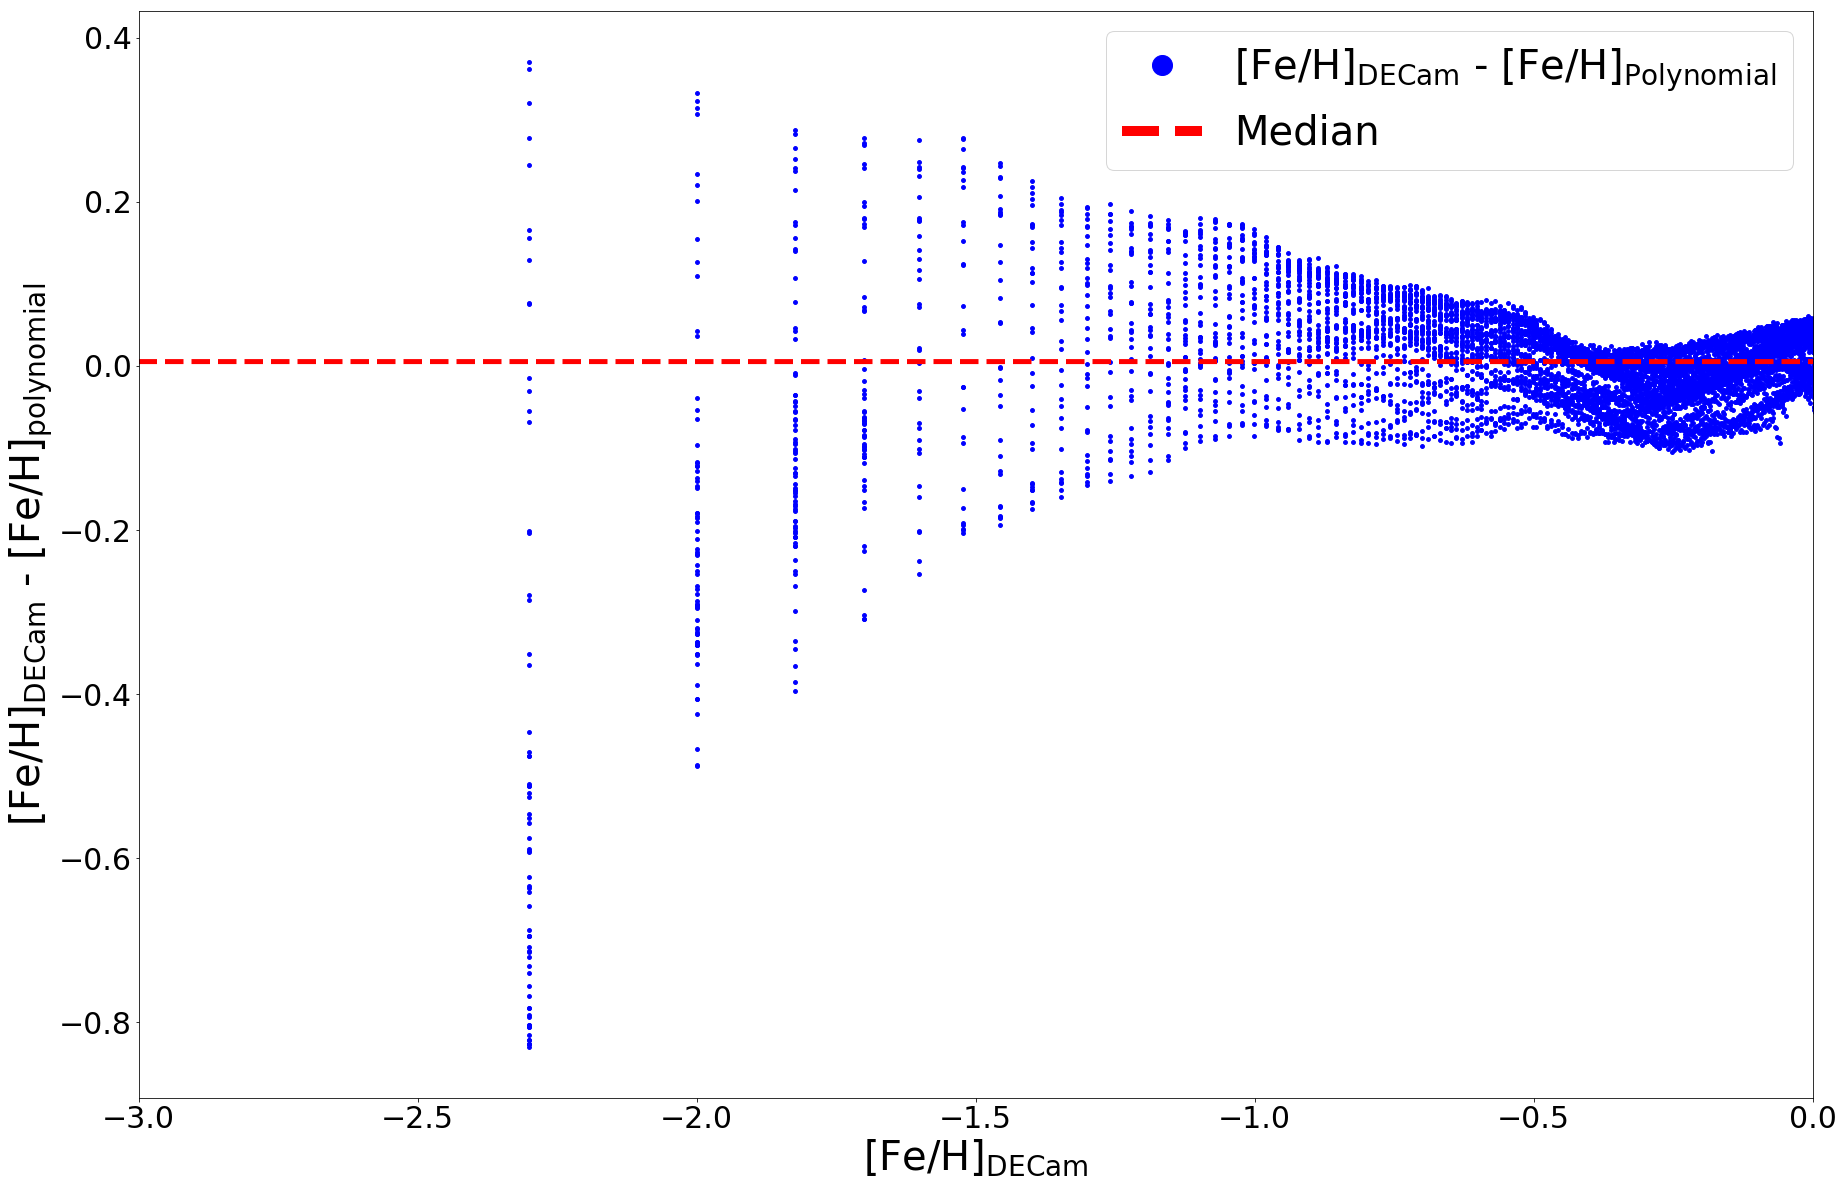

In [30]:
blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{Polynomial}$')
red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

delta = feh_des - fitted[127]

fig, ax = plt.subplots(figsize=(30,20))

ax.scatter(feh_des,delta,c='b',s=15)
plt.xlabel('[Fe/H]$_\mathregular{DECam}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{polynomial}$',fontsize=40)
plt.plot(x,y,'--',c='r',linewidth=5,label='Median')
ax.set_xlim(-3,0)
        
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(handles=[blue,red],fontsize=40)


### Median of above residuals

In [25]:
np.nanmedian(delta)

0.005307141493773315